In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter as sf

In [2]:
from line_profiler import profile
%load_ext line_profiler

In [3]:
"""
TODO 10/3/2023
-Why skip 6?
-Why smoothing parameters?
-Why grade distance?
-Set up method of getting lat, lon explicitly
-revamp so each method takes a 'series',
 and outputs a 'series'
"""

"\nTODO 10/3/2023\n-Why skip 6?\n-Why smoothing parameters?\n-Why grade distance?\n-Set up method of getting lat, lon explicitly\n-revamp so each method takes a 'series',\n and outputs a 'series'\n"

In [4]:
# SKIPPING EVERY 6 POINTS TO MATCH ERICA
rt_ = gpd.read_file("./Data/Routes/rt22_pts.shp")[::6]
#lidar was highest res data for elevation

rt_ = rt_.reset_index(drop=True)
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")
seattle = seattle[(seattle['WATER'] != 1)]

In [5]:
stops = gpd.read_file('./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp')

In [6]:
signals_1 = gpd.read_file('./Data/Signals/Traffic_Signals.shp')

In [7]:
def get_lat_lon(pt):
    '''
    get_lat_lon() takes in a shapely geometry point,
    and returns the latitude and longitude as a tuple
    
    Parameters:
    pt: a shapely geometry point
    
    Returns:
    a tuple containing Latitude and Longitude, in that order
    '''
    
    # Conver the point to a string
    
    # Check for formatting
    if ('MULTIPOINT' in str(pt)):
        pt = str(pt)[5:]
        return float((pt)[7:-1].split(" ")[0]), float((pt)[7:-1].split(" ")[1])
    else:
        return float((str(pt)[7:-1]).split(" ")[0]), float((str(pt)[7:-1]).split(" ")[1])

In [8]:
def list_contains(ls, val):
    if (val in ls):
        return True
    else:
        return False

In [9]:
def get_stops(s_gdf, rt_num:str):
    """
    get_stops() takes in an aggregate of bus stops,
    and processes it such that only the stops of the desired route are available
    
    Parameters:
    s_gdf: a geodataframe of bus stop information, including a list of
           routes that arrive there, and geometry of each stop
    rt_num: a string that is the number or ID of the route to be found.
    
    Returns:
    a geodataframe containing solely the data for stops with that route.
    """ 
    
    # Copy the dataframe over so no persistence errors
    temp = s_gdf.copy()
    
    # Fill NAN values with zero
    temp['ROUTE_LIST'].fillna(value = str(0), inplace = True)
    
    # Split the route list into an actual list
    temp['ROUTE_LIST_R'] = temp['ROUTE_LIST'].str.split(" ")
    
    # Use the list_contains method to check if the list contains target route
    temp['RT_MATCH'] = False
    temp['RT_MATCH'] = temp.apply(lambda x: list_contains(ls = list(x['ROUTE_LIST_R']),
                                                          val = rt_num),
                                            axis = 1)
    
    # Filter the stops to only the ones where the target route arrives
    test_stops = temp[(temp['RT_MATCH'] == True) & (temp["IN_SERVICE"] == "Y")]
    
    return test_stops

In [10]:
def haversine_formula(lat1:float,
                      lon1:float,
                      lat2:float,
                      lon2:float,
                      r:int = 6371):
    """
    haversine_formula() is a method to calculate the distance
    between two latitude and longitude points on earth, using
    the haversine formula. This has been adapted from:
    
    https://stackoverflow.com/questions/43577086/pandas-calculate-haversine-distance-within-each-group-of-rows
    and
    https://www.omnicalculator.com/other/latitude-longitude-distance
    
    Parameters:
    lat1: latitude of point 1 as a float
    lon1: longitude of point 1 as a float
    lat2: latitude of point 2 as a float
    lon2: longitude of point 2 as a float
    r: radius of earth, default 6371 km

    Returns:
    distance, in kilometers, between the points
    """
    
    # Calculate the first section of the haversine
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    
    # Calculate and return the second section of the haversine in km
    return r * 2 * np.arcsin(np.sqrt(a)) / 100 * 1.609344

In [11]:
route_geometry = rt_['geometry']
route_elevation = rt_['Z']
all_stops = stops
all_signals = signals_1['geometry'].reset_index(drop=True)
route_stops = get_stops(all_stops, "22")['geometry'].reset_index(drop=True)

In [33]:
rm = RouteMap(route_geometry, route_elevation, route_stops, all_signals)

In [3]:
streets = gpd.read_file("./Data/Seattle_Streets/Seattle_Streets.shp")

In [37]:
streets

,OBJECTID,ARTCLASS,COMPKEY,UNITID,UNITID2,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,...,STREETTYPE,PVMTCONDIN,PVMTCOND_1,TRANCLASS,TRANDESCRI,SLOPE_PCT,PVMTCATEGO,PARKBOULEV,SHAPE_Leng,geometry
0,2552264,2.0,1006,00010,0120,000100120,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,1ST AVE,SENECA ST,UNIVERSITY ST,...,Downtown Neighborhood,98.0,62.0,1,PRINCIPAL TRANSIT ROUTE,4.0,ART,N,0.000967,"LINESTRING (-122.33754 47.60612, -122.33820 47..."
1,2552265,2.0,1009,00010,0150,000100150,1ST AVE BETWEEN PIKE ST AND PINE ST,1ST AVE,PIKE ST,PINE ST,...,Downtown Neighborhood,51.0,58.0,1,PRINCIPAL TRANSIT ROUTE,5.0,ART,N,0.001346,"LINESTRING (-122.34001 47.60882, -122.34092 47..."
2,2552266,0.0,1032,00015,0080,000150080,1ST AVE N BETWEEN VALLEY UPPER ST AND ALOHA ST,1ST AVE N,VALLEY UPPER ST,ALOHA ST,...,Neighborhood Yield Street,0.0,0.0,0,NOT DESIGNATED,17.0,NON-ART,N,0.000815,"LINESTRING (-122.35538 47.62637, -122.35538 47..."
3,2552267,0.0,1051,00015,0230,000150230,1ST AVE N BETWEEN LYNN ST AND MCGRAW S ST,1ST AVE N,LYNN ST,MCGRAW S ST,...,Neighborhood Yield Street,9.0,0.0,0,NOT DESIGNATED,3.0,NON-ART,N,0.000479,"LINESTRING (-122.35558 47.63912, -122.35557 47..."
4,2552268,0.0,1060,00015,0282,000150282,1ST AVE N BETWEEN FULTON S ST AND FULTON N ST,1ST AVE N,FULTON S ST,FULTON N ST,...,Neighborhood Yield Street,0.0,0.0,0,NOT DESIGNATED,5.0,NON-ART,N,0.000200,"LINESTRING (-122.35553 47.64562, -122.35553 47..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23848,2576112,0.0,673443,18235,0141,182350141,SW THISTLE ST BETWEEN DEAD END AND 14TH AVE SW,SW THISTLE ST,DEAD END,14TH AVE SW,...,None,0.0,0.0,0,None,38.0,None,N,0.000150,"LINESTRING (-122.35313 47.52830, -122.35328 47..."
23849,2576113,2.0,5393,02705,1170,027051170,35TH AVE NE BETWEEN 33RD PL NE AND NE 120TH ST,35TH AVE NE,33RD PL NE,NE 120TH ST,...,Urban Center Connector,59.0,0.0,3,MINOR TRANSIT ROUTE,5.0,ART,N,0.001163,"LINESTRING (-122.29152 47.71435, -122.29153 47..."
23850,2576114,0.0,6782,03590,0750,035900750,44TH PL SW BETWEEN DEAD END AND SW AUSTIN ST,44TH PL SW,DEAD END,SW AUSTIN ST,...,Neighborhood Yield Street,79.0,0.0,0,NOT DESIGNATED,1.0,NON-ART,N,0.000920,"LINESTRING (-122.38972 47.53585, -122.38970 47..."
23851,2576115,3.0,11293,08115,0430,081150430,LATONA AVE NE BETWEEN NE 43RD ST AND NE 44TH ST,LATONA AVE NE,NE 43RD ST,NE 44TH ST,...,Neighborhood Corridor,91.0,0.0,3,MINOR TRANSIT ROUTE,6.0,ART,N,0.001262,"LINESTRING (-122.32514 47.65895, -122.32512 47..."


In [38]:
streets.at[streets['SEGLENGTH'].idxmax(), 'UNITDESC']

'I90 WB BETWEEN MID CHANNEL AND I90 WB TUNNEL E'

In [26]:
speeds = streets[['geometry', 'SPEEDLIMIT']]
speeds['geometry'] = speeds['geometry'].astype(str)
speeds['geometry'].str[12:-1].split(", ")

/tmp/ipykernel_1524/3011210723.py:2: UserWarning: Geometry column does not contain geometry.
  speeds['geometry'] = speeds['geometry'].astype(str)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AttributeError: 'Series' object has no attribute 'split'

In [17]:
@profile
def get_limit(lon, lat, data):
    lim = data[data['geometry'].str.contains("{} {}".format(lon, lat))]['SPEEDLIMIT'].max()
    print(lim)
    return lim

In [18]:
%lprun -f get_limit get_limit('-122.337540', '47.60612', speeds)

nan


Timer unit: 1e-09 s

Total time: 0.0315628 s
File: /tmp/ipykernel_1524/3589953857.py
Function: get_limit at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           @profile
     2                                           def get_limit(lon, lat, data):
     3         1   31038071.0    3e+07     98.3      lim = data[data['geometry'].str.contains("{} {}".format(lon, lat))]['SPEEDLIMIT'].max()
     4         1     524509.0 524509.0      1.7      print(lim)
     5         1        252.0    252.0      0.0      return lim

In [10]:
#route_map_test = rm.get_gdf()
fig, ax = plt.subplots(1, figsize = (12, 30))
ax.set_xlim(-122.44, -122.23)
ax.set_ylim(47.49, 47.74)
seattle.plot(color="#E6E6E3", ax=ax)
route_map_test.plot(color='green', markersize=2, ax=ax)
route_map_test[route_map_test['is_stop'] == True].plot(color='lime', markersize=2, ax=ax)
#signals_1.plot(color = 'red', markersize = 2, ax=ax)
route_map_test[route_map_test['is_signal'] == True].plot(color='red', markersize=2, ax=ax)
transit.plot(color='yellow', ax = ax)

NameError: name 'rm' is not defined

<Axes: xlabel='cumulative_distance[km]', ylabel='elevation[km]'>

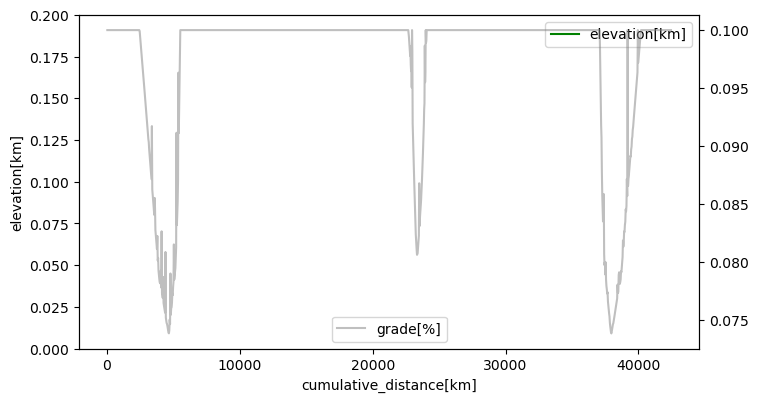

In [35]:
rm.plot()

In [ ]:
#%lprun -f haversine_formula RouteMap(route_geometry, route_elevation, route_stops, all_signals)

In [32]:
class RouteMap:
    def __init__(self,
                 geometry,
                 elevation,
                 stops = None,
                 signals = None,
                 threshold = .015,
                 debug = False):
        # Set the global debug parameter
        self._debug = debug
        
        # Set the global distance threshold, default is .015 km.
        self._dist_threshold = threshold
        
        # Generate the empty route dataframe
        self._route_df = pd.DataFrame()
        
        # Assign the geometry input to the route dataframe
        self._route_df['geometry'] = geometry
        
        # Assign the elevation to the route dataframe
        self._route_df['elevation[km]'] = elevation/100
        
        # Get the latitude and longitude from the geometry of the route dataframe
        self._route_df[['latitude', 'longitude']] = self.geo_to_la_lon(self._route_df['geometry'])
        
        # Generate joint geometry for generating point distances
        self._joint_geometry = self.get_joint_geometry()
        
        # Calculate the distance between points and cumulative distance
        self._route_df['point_distances[km]'] = self.calc_point_distances()
        self._route_df['cumulative_distance[km]'] = self.calc_cum_distances()
        
        # If there is stop data, 
        if (str(type(stops)) != "<class 'NoneType'>"):
            
            # Assign bus stop data using assign_stops
            self._route_df['is_stop'] = self.assign_stops(stops, 0)
        
        # Otherwise:
        else:
            
            # Set the default value to 'None'.
            self._route_df['is_stop'] = False
            
        # If debugging, notify of assigned stops.
        if(debug): 
            print('stops assigned')
        
        # If there is signal data,
        if (str(type(signals)) != "<class 'NoneType'>"):
            
            # Assign the route points with respective stops using assign_stops
            self._route_df['is_signal'] = self.assign_stops(signals, 1)
            
        # Otherwise:
        else:
            
            # Assign default signal value of None.
            self._route_df['is_signal'] = False
            
        # If debugging, notify of assigned stops.
        if(debug): 
            print('signals assigned')
            
        
    def calc_point_distances(self):
        """
        calc_point_distances calculates the distances between the route points,
        and returns a pandas series of distances between points in the route.
        
        Parameters:
        None.
        
        Returns:
        a series of distances with indexes corresponding to the route data,
        in units of kilometers.
        """
        
        # Get a copy of the joint_geometry.
        joint_geometry = self._joint_geometry.copy()
        
        # Calculate the distance between each point using the haversine formula.
        dist_traveled = joint_geometry.apply(lambda x: haversine_formula(x['lat1'],
                                                                         x['lon1'],
                                                                         x['lat2'],
                                                                         x['lat2']),
                                             axis=1)
        
        # Return the distance series.
        return dist_traveled
    
    
    def calc_cum_distances(self):
        """
        calc_cum_distances generates a pandas series tallying the
        cumulative distance travelled between points on the route.
        
        Parameters:
        None.
        
        Returns:
        a pandas series cumulatively summing the kilometers traveled
        by the bus.
        """
        
        # Get the route's point distances.
        point_distances = self._route_df['point_distances[km]']
        
        # tally the cumulative sum and return it.
        return point_distances.cumsum()


    def assign_stops(self, stops, stop_type):
        '''
        method assign_stops takes in the existing route map,
        as well as stop geometry and types of stops, and then
        assigns points on the route that stop classification.
        
        Parameters:
        stops: a pandas series of stop points as geometry
        stop_type: a parameter where 0 means a bus stop,
                   and 1 means a signal light.
                   
        Returns:
        a pandas series indicating stops using the same index as route points.
        '''
        
        # Get a copy of the joint geometry.
        joint_geometry = self._joint_geometry.copy()
        
        # Get the latitude and longitude of the stop data
        stop_lat_lons = self.geo_to_la_lon(stops)
        # set the default stop distance to 999,999,999 kilometers
        joint_geometry['stop_dist'] = 999999999
        
        # Set the default state for being a stop to be False
        joint_geometry['is_stop'] = False
        
        # Loop through each stop in the data
        for i in range(len(stop_lat_lons)):
            
            # If debugging, print progress
            if self._debug: print('{0:.2f}%     '.format(i/len(joint_geometry)*100), end = "\r")
            
            # get the latitude and longitude of the current stop
            la1 = stop_lat_lons['latitude'][i]
            lo1 = stop_lat_lons['longitude'][i]
            
            # using the joint geometry, apply the haversine formula between each point in the route
            # and the current stop.
            joint_geometry['stop_dist'] = joint_geometry.apply(lambda x: haversine_formula(x['lat1'],
                                                                                           x['lon1'],
                                                                                           la1,
                                                                                           lo1),
                                                               axis=1)
            
            # Get the index of the lowest distance route point to the stop
            cord_id = joint_geometry['stop_dist'].idxmin()
            min_val = joint_geometry['stop_dist'].min()
            
            # if the stop type is a bus stop,
            if(stop_type == 0):
                
                # assign the stop as a bus stop.
                joint_geometry.at[cord_id, 'is_stop'] = True
                
            # If the stop type is a stop signal, and the signal is closer to the stop than the threshold,
            elif(stop_type == 1):
                
                # categorize the point index as a signal stop.
                joint_geometry.at[cord_id, 'is_stop'] = True
            else:
                # Otherwise, dont categorize it as a stop
                joint_geometry.at[cord_id, 'is_stop'] = False
                
        # Return a pandas series of booleans for a stop with indexes corresponding to the route idxs.
        return joint_geometry['is_stop']
    
    
    def smooth_elevation(self, lg:int = 43, deg:int = 3):
        """
        smooth_elevation applies a savgol filter to the
        elevation data in order to de-noise it.

        Parameters:
        lg: length of the filter in number of points per sample,
            default is 43, as an int.
        deg: degree int for filter polynomial, default is 3.

        Returns:
        a series containing the smoothed elevation values.
        """
        # get the points that will be smoothed
        elev_points = self._route_df[('elevation[km]')].values

        # Apply the savgol filter to the points
        y_new = sf(elev_points,
                   lg,
                   deg,
                   axis = 0)

        # replace the elevation values with the
        # smoothed elevation values.
        tmp = pd.DataFrame()
        tmp['elevation[km]'] = y_new
        
        # return the series
        return tmp['elevation[km]'] 
        
        
    def get_joint_geometry(self):
        lat1 = self._route_df['latitude']
        lon1 = self._route_df['longitude']
        lat2 = self._route_df['latitude'].shift(-1)
        lon2 = self._route_df['longitude'].shift(-1)
        joint_geometry = pd.DataFrame()
        joint_geometry['lat1'] = lat1
        joint_geometry['lon1'] = lon1
        joint_geometry['lat2'] = lat2
        joint_geometry['lon2'] = lon2
        joint_geometry.dropna(inplace=True)
        return joint_geometry
        
        
    def get_gdf(self):
        return gpd.GeoDataFrame(self._route_df)
    
    
    def remove_stops(self):
        self._route_df['is_stop'] = False
        return None
    
    
    def remove_signals(self):
        self._route_df['is_signal'] = False
        return None
    
    
    def get_stops(self):
        return self._route_df[self._route_df['is_stop'] == True].copy()
    
    
    def get_signals(self):
        return self._route_df[self._route_df['is_signal'] == True].copy()
    
    
    def get_elevation(self):
        return self._route_df['elevation[km]'].copy()
    
    
    def get_distances(self):
        return self._route_df[['point_distances[km]', 'cumulative_distance[km]']].copy()
    
    
    def get_grade(self):
        elevation = self.get_elevation()
        distance = self.get_distances()['point_distances[km]']
        grade = elevation / distance
        grade = grade.clip(upper=.10, lower=-.10)
        return grade
        
    def geo_to_la_lon(self, geometry):
        tmp_df = pd.DataFrame((geometry.apply(get_lat_lon)).tolist())
        tmp_df.columns = ['latitude','longitude']
        return tmp_df[['latitude', 'longitude']]
    
    
    def plot(self):
        fig, ax = plt.subplots(1, figsize = (8, 4.333))
        self._route_df['grade[%]'] = self.get_grade()
        self._route_df.plot(x='cumulative_distance[km]',
                            y='elevation[km]',
                            ax=ax,
                            c='Green')
        self.get_stops().plot.scatter(x='cumulative_distance[km]',
                                    y='elevation[km]',
                                    ax=ax,
                                    c='lime',
                                    s=20)
        self.get_signals().plot.scatter(x='cumulative_distance[km]',
                                      y='elevation[km]',
                                      ax=ax,
                                      c='orange',
                                      s=20)
        ax1=ax.twinx()
        self._route_df.plot(x='cumulative_distance[km]',
                            y='grade[%]',
                            ax=ax1,
                            c='grey',
                            alpha=0.5)

        ax.set_ylim(0,.2)
        return ax

In [6]:
signals_2 = gpd.read_file('./Data/Signals/traffic_signals2.shp')

In [7]:
signals_2['Route_Num'].unique()

array(['101', '102', '111', '116', '143', '150', '154', '156', '157',
       '158', '159', '168', '177', '178', '179', '180', '181', '182',
       '183', '187', '190', '192', '193', '197', '22'], dtype=object)

In [26]:
all_signals

0       MULTIPOINT (-122.35530 47.68694)
1       MULTIPOINT (-122.33784 47.61528)
2       MULTIPOINT (-122.35165 47.61758)
3       MULTIPOINT (-122.32137 47.59583)
4       MULTIPOINT (-122.33668 47.61021)
                      ...               
1022    MULTIPOINT (-122.31678 47.61040)
1023    MULTIPOINT (-122.31678 47.61156)
1024    MULTIPOINT (-122.31964 47.59918)
1025    MULTIPOINT (-122.33591 47.60059)
1026    MULTIPOINT (-122.29033 47.67760)
Name: geometry, Length: 1027, dtype: geometry

In [23]:
def get_slope_grade(i_gdf):
    """
    get_slope_grade takes in a geodataframe containing distances
    between points and elevation differences, and returns
    the grade of each point on the slope.
    
    Parameters:
    i_gdf: geodataframe with differences in distance and elevation
           as elevation_diff['km']
    """
    
    gdf = i_gdf.copy()
    
    # Calculate the %grade of the slope
    gdf['grade[%]'] = gdf['elevation_diff[km]'] / gdf['dist_traveled[km]']
    gdf['grade[%]'] = gdf['grade[%]'].clip(upper=.10, lower=-.10)
    
    # ERICA GRADE CALCULATION ----------------------------
    grade_SG = [0]
    y_new = list(gdf['elevation[km]']*1000)

    for i in range(1,len(y_new)):
        grade_SG.append((y_new[i]-y_new[i-1])/10.97)
    
    gdf['Erica_grade[%]'] = grade_SG
    gdf['Erica_grade[%]'] = gdf['Erica_grade[%]']
    # End Erica Grade Calculation ------------------------
    
    # Return the grade
    return gdf

In [16]:
## DEPRICATED METHODS ##

'''
    def assign_stops(self, stops, stop_type):
        '''
        Optimization possibilities:
        - Figuring out the closest
        - can use python profiler
        - joint_geometry persistence?
        '''
        joint_geometry = self._joint_geometry.copy()
        stop_geo = stops
        joint_geometry['stop_dist'] = 9999999
        joint_geometry['is_stop'] = False
        for i in range(len(stop_geo)):
            if self._debug: print('{0:.2f}%     '.format(i/len(joint_geometry)*100), end = "\r")
            s1 = stop_geo[i]
            joint_geometry['stop_dist'] = joint_geometry.apply(lambda x: haversine_formula_2(x['g1'], s1), axis=1)
            cord_id = joint_geometry['stop_dist'].idxmin()
            if(stop_type == 0):
                joint_geometry.at[cord_id, 'is_stop'] = True
            elif(stop_type == 1 and joint_geometry.at[cord_id, 'stop_dist'] <= self._dist_threshold):
                    joint_geometry.at[cord_id, 'is_stop'] = True
            else:
                joint_geometry.at[cord_id, 'is_stop'] = False
        return joint_geometry['is_stop']



def haversine_formula_2(pt1,
                        pt2,
                        r:int = 6371):
    """
    haversine_formula() is a method to calculate the distance
    between two latitude and longitude points on earth, using
    the haversine formula. This has been adapted from:
    
    https://stackoverflow.com/questions/43577086/pandas-calculate-haversine-distance-within-each-group-of-rows
    and
    https://www.omnicalculator.com/other/latitude-longitude-distance
    
    Parameters:
    lat1: latitude of point 1 as a float
    lon1: longitude of point 1 as a float
    lat2: latitude of point 2 as a float
    lon2: longitude of point 2 as a float
    r: radius of earth, default 6371 km

    Returns:
    distance, in kilometers, between the points
    """
    
    lat1, lon1 = get_lat_lon(pt1)
    lat2, lon2 = get_lat_lon(pt2)
    
    
    # Calculate the first section of the haversine
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    
    # Calculate and return the second section of the haversine in km
    return r * 2 * np.arcsin(np.sqrt(a)) / 100 * 1.609344
    
    
def route_distance(i_gdf):
    """
    route_distance() takes in a geodataframe of a route,
    and appends the cumulative distance between coordinates.
    
    Parameters:
    i_gdf: geodataframe of a route, with the following columns:
         [Id, ORIG_FID, SHAPE_Leng, Z, geometry]
    
    Returns: 
    The geodataframe with distance appended as a new column.
    """
    
    # Copy input dataframe so no persistence errors
    gdf = i_gdf.copy()
    
    # Concatenate the geometry column and set it to a string
    # with only the coordinates
    temp_geo = (gdf['geometry']).astype(str).apply(lambda x: x[7:-1])
    
    # Split the longitude and latitude into two columns 
    # and set it as a float again
    gdf[['longitude', 'latitude']] = (temp_geo.str.split(" ",
                                                         n=1,
                                                         expand=True)).astype(float)
    
    # Set up a temporary set of the upcoming latitude and longitude
    gdf[['lon2', 'lat2']] = (gdf[['longitude', 'latitude']].shift(-1)).astype(float)

    # Apply the haversine formula between the current and upcoming points,
    # set it as distance travelled in KM
    gdf['dist_traveled[km]'] = gdf.apply(lambda x: haversine_formula(x['longitude'],
                                                                     x['latitude'],
                                                                     x['lon2'],
                                                                     x['lat2']), 
                                         axis=1)
    
    # Drop the temporary columns
    gdf = gdf.drop(columns=['lat2', 'lon2'])
    
    # Shift the distance traveled to the proper point
    gdf['dist_traveled[km]'] = gdf['dist_traveled[km]'].shift(1)
    
    # Sum the distance traveled
    gdf['cumulative_distance[km]'] = gdf['dist_traveled[km]'].cumsum()
    
    # THIS LINE IS TO MATCH ERICA'S DISTANCE CALCULATION
    gdf['Erica_distance[km]'] = gdf.index * 6 * .3048 / 1000
    
    
    return gdf
    
    
    
def confirm_stops(i_gdf, st_gdf):
    """
    confirm_stops takes in a geodataframe with route geometry,
    and a geodataframe containing stop geometry, and then
    assigns the route geometry stop assignments based on closest matching
    coordinates.
    """
    
    gdf = i_gdf.copy()
    s_gdf = st_gdf.copy()
    
    gdf['is_stop'] = False
    
    # Concatenate the geometry column and set it to a string
    # with only the coordinates
    temp_geo = (s_gdf['geometry']).astype(str).apply(lambda x: x[7:-1])
    
    # Split the longitude and latitude into two columns 
    # and set it as a float again
    s_gdf[['longitude', 'latitude']] = (temp_geo.str.split(" ",
                                                           n=1,
                                                           expand=True)).astype(float)
    gdf['stop_dist'] = 9999999
    closest_point = ""
    for i in range(len(s_gdf)):
        print('{0:.2f}%     '.format(i/len(s_gdf)*100), end = "\r")
        s_lon = s_gdf.iloc[i,
                           s_gdf.columns.get_loc('longitude')]
        s_lat = s_gdf.iloc[i, 
                           s_gdf.columns.get_loc('latitude')]

        gdf['stop_dist'] = gdf.apply(lambda x: haversine_formula(lat1 = x['latitude'],
                                                                 lon1 = x['longitude'],
                                                                 lat2 = s_lat,
                                                                 lon2 = s_lon,),
                                     axis=1)
        #print(gdf['stop_dist'].min(), gdf['stop_dist'].idxmin())
        cord_id = gdf['stop_dist'].idxmin()
        gdf.at[cord_id, 'is_stop'] = True
        
    print('100%    ')
    return gdf
    
    
    
    
    
    def confirm_signals(i_gdf, st_gdf):
    '''
    confirm_signals() takes in an aggregate of signal lights,
    and then checks which signals are on the pathway of the current route.
    '''
    
    gdf = i_gdf.copy()
    s_gdf = st_gdf.copy()
    
    gdf['is_signal'] = False
    
    # Split the longitude and latitude into two columns 
    # and set it as a float again
    tmp_df = pd.DataFrame((s_gdf['geometry'].apply(get_lat_lon)).tolist())
    tmp_df.columns = ['latitude','longitude']
    s_gdf[['latitude', 'longitude']] = tmp_df[['latitude', 'longitude']]
    gdf['stop_dist'] = 9999999
    closest_point = ""
    for i in range(len(s_gdf)):
        print('{0:.2f}%     '.format(i/len(s_gdf)*100), end = "\r")
        s_lon = s_gdf.iloc[i, s_gdf.columns.get_loc('longitude')]
        s_lat = s_gdf.iloc[i, s_gdf.columns.get_loc('latitude')]

        gdf['stop_dist'] = gdf.apply(lambda x: haversine_formula(lat1 = x['latitude'],
                                                                 lon1 = x['longitude'],
                                                                 lat2 = s_lat,
                                                                 lon2 = s_lon,),
                                     axis=1)
        #print(gdf['stop_dist'].min(), gdf['stop_dist'].idxmin())
        cord_id = gdf['stop_dist'].idxmin()
        if (gdf['stop_dist'].min() <= .015):
            gdf.at[cord_id, 'is_signal'] = True
            
    return gdf
    
    
def check_between(pt1, pt2, targpt):
    pt1_lat, pt1_lon = get_lat_lon(pt1)
    pt2_lat, pt2_lon = get_lat_lon(pt2)
    tpt_lat, tpt_lon = get_lat_lon(targpt)
    
    d_lat1 = tpt_lat - pt1_lat
    d_lon1 = tpt_lon - pt1_lon
    
    d_lat_0 = pt2_lat - pt1_lat
    d_lon_0 = pt2_lon - pt2_lon
    
    cross = d_lat1 * d_lat_0 - d_lon1 * d_lon_0
    
    if (cross != 0):
        return False
    
    else:
        return True
        
        
def route_elevation(i_gdf):
    """
    route_elevation takes in a geodataframe with Z elevation,
    and converts the distance in feet to kilometers
    
    Parameters:
    i_gdf: geodataframe containing column Z
         with altitude in feet.
    """
    
    # Copy input dataframe so no persistence errors
    gdf = i_gdf.copy()
    
    # Rename the z to elevation, use units of km
    gdf = gdf.rename(columns = {'Z':'elevation[km]'})
    
    # Convert elevation to km
    gdf['elevation[km]'] *= 0.3048 / 1000 # constant for conversion
                                        # between feet and km
    
    # Generate the elevation difference between points
    gdf['elevation_diff[km]'] = gdf['elevation[km]'].diff()
        
    return gdf
    
    
def smooth_elevation(i_gdf):
    """
    smooth_elevation applies a savgol filter to the
    elevation data in order to de-noise it.
    
    Parameters:
    i_gdf: a geodataframe containing elevation data
         titled 'elevation[km]'. 
    
    Returns:
    a geodataframe that has been smoothed.
    
    TODO 6% check
    each 100 m with poly
    2nd od pnm 
    """
    
    # Copy input dataframe so no persistence errors
    gdf = i_gdf.copy()
    
    # get the points that will be smoothed
    elev_points = gdf[('elevation[km]')].values
    
    # Select the savgol filter parameters,
    # same as what Erica used, no understood reason
    length = 43 # check doc for pt params
    degree = 3
    
    # Apply the savgol filter to the points
    y_new = sf(elev_points,
               length,
               degree,
               axis = 0)
    
    # replace the elevation values with the
    # smoothed elevation values.
    gdf['elevation[km]'] = y_new
    
    # regenerate elevation difference
    gdf['elevation_diff[km]'] = gdf['elevation[km]'].diff()
    
    # return the dataframe
    return gdf
'''

<Axes: xlabel='cumulative_distance[km]', ylabel='elevation[km]'>

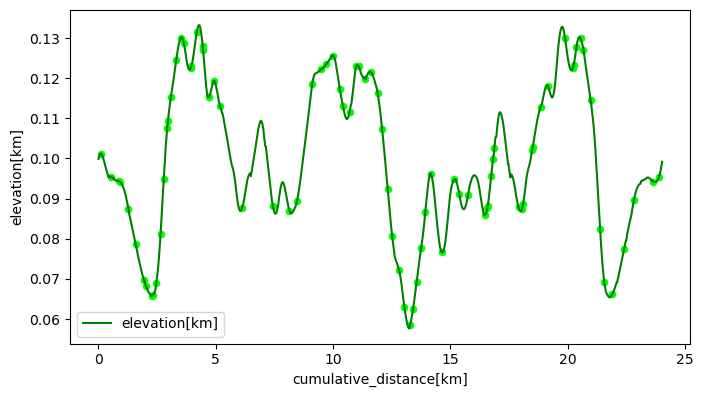

In [35]:
fig, ax = plt.subplots(1, figsize = (8, 4.333))
elev_map = rt_22_sm[['elevation[km]',
                       'dist_traveled[km]',
                       'cumulative_distance[km]', 
                       'Erica_distance[km]',
                       'is_stop',
                       'is_signal']]

elev_map.plot(x='cumulative_distance[km]',
              y='elevation[km]',
              ax=ax,
              c='Green')
elev_map[elev_map['is_stop']==True].plot.scatter(x='cumulative_distance[km]',
                                                 y='elevation[km]',
                                                 ax=ax,
                                                 c='lime',
                                                 s=20)

In [41]:
grad_rt_22 = get_slope_grade(rt_22_sm)

(-0.15, 0.15)

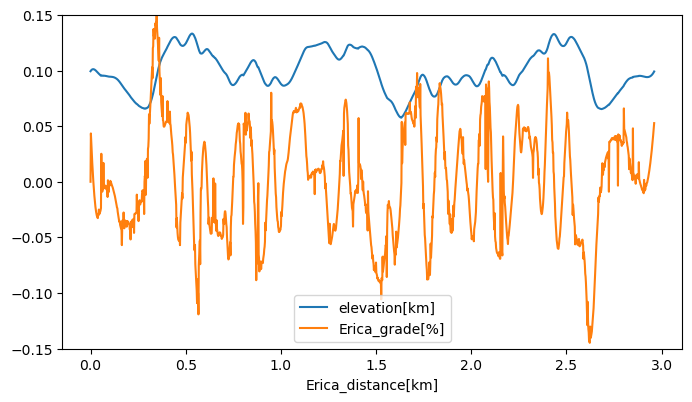

In [42]:
fig, ax = plt.subplots(1, figsize = (8, 4.333))
grad_map = grad_rt_22[['cumulative_distance[km]',
                       'grade[%]',
                       'Erica_distance[km]',
                       'Erica_grade[%]']]
#grad_map.plot(x='cumulative_distance[km]', y='grade[%]', ax=ax)
elev_map.plot(x='Erica_distance[km]', y='elevation[km]', ax=ax)
grad_map.plot(x='Erica_distance[km]', y='Erica_grade[%]', ax=ax)
ax.set_ylim(-.15, .15)

(0.0, 0.2)

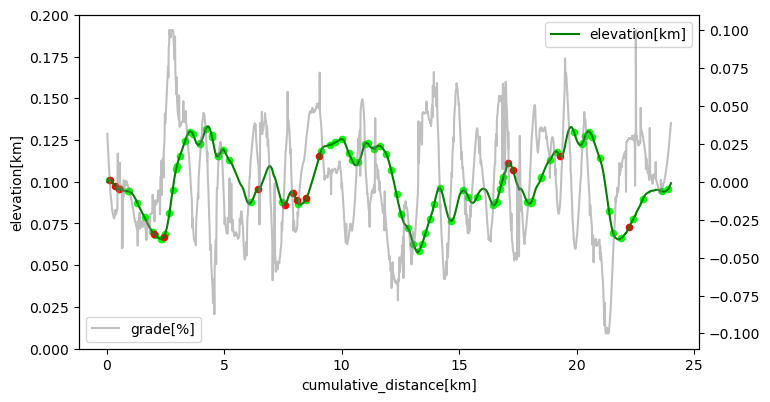

In [43]:
fig, ax = plt.subplots(1, figsize = (8, 4.333))
elev_map.plot(x='cumulative_distance[km]',
              y='elevation[km]',
              ax=ax,
              c='Green')
elev_map[elev_map['is_stop']==True].plot.scatter(x='cumulative_distance[km]',
                                                 y='elevation[km]',
                                                 ax=ax,
                                                 c='lime',
                                                 s=20)
elev_map[elev_map['is_signal']==True].plot.scatter(x='cumulative_distance[km]',
                                                 y='elevation[km]',
                                                 ax=ax,
                                                 c='red',
                                                 s=20)
ax1=ax.twinx()
grad_map.plot(x='cumulative_distance[km]',
              y='grade[%]',
              ax=ax1,
              c='grey',
              alpha=0.5)

ax.set_ylim(0,.2)